## About
This notebook takes all IDRs in the human proteome, identifies those which are (1) over 100 amino acids and (2) have an attractive $\epsilon$ value and then predicts full phase diagrams for all these and plot the critical concentration ($\phi_C$) and critical temperature ($T_c$) with IDRs colored by their $\epsilon$ value. 

## Figures
This notebook generates panels for **Fig. S7**

## Install
This notebook requires the [`SHEPHARD` package](https://shephard.readthedocs.io/en/latest/) which can be installed by PyPI using

    pip install shephard


In [1]:
import numpy as np
import matplotlib
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from sparrow import Protein
import protfasta

from finches import Mpipi_frontend, CALVADOS_frontend


In [2]:
from shephard.apis import uniprot
from shephard.interfaces import si_domains, si_protein_attributes

In [3]:
HP = uniprot.uniprot_fasta_to_proteome('../../../data/human_proteome_clean.fasta')

# NOTE this selector defines the mode with which we run this analysis. Must be one of
# mpipi or calvados
mode = 'mpipi'

# read in annotated IDR domains
if mode == 'mpipi':
    si_domains.add_domains_from_file(HP, '../../../data/shprd_IDR_domains_with_atts_tc_eps.tsv')
    xf = Mpipi_frontend()
    
elif mode == 'calvados':
    si_domains.add_domains_from_file(HP, '../../../data/shprd_IDR_domains_with_atts_tc_eps_CALVADOS.tsv')
    xf =  CALVADOS_frontend()
else:
    raise Exception('mode must be mpipi or calvados')

# cast to floats (note in updated SHEPHARD we can do this automatically, but we wrote this code so long
# ago that functionality did not yet exist! Basically what the blck does below is it reads the attributes
# as strings and then OVERWRITES those same attributes (hence safe=False) as floats. 
for d in HP.domains:

    # NB calvados critical temperatures are labelled as critical_temperature_mpipi as well :-( 
    d.add_attribute('critical_temperature_mpipi', float(d.attribute('critical_temperature_mpipi')), safe=False)
    d.add_attribute('eps', float(d.attribute('eps')), safe=False)

# cycle over all domains and fliter for those where the IDR is > 100 amino acids
all_idrs = []
for d in HP.domains:
    if len(d) > 100:
        all_idrs.append(d)

# get IDRs (as shephard.domain.Domain objects) sorted in terms of their epsilon value
sorted_idrs = sorted(all_idrs, key=lambda domain: domain.attribute('eps'))

# get the raw epsilon values for the sorted IDRs
sorted_eps = [d.attribute('eps') for d in sorted_idrs]   

# get the critical temperature values for the sorted IDRs
sorted_tc = [d.attribute('critical_temperature_mpipi') for d in sorted_idrs]   

# get the IDR lengths for the sorted IDRs
sorted_lengths = [len(d) for d in sorted_idrs]   
print(f"This analysis identified {len(sorted_lengths)} IDRs over 100 amino acids in length")

This analysis identified 9909 IDRs over 100 amino acids in length


In [4]:
# next we find he IDRs with ATTRACTIVE epsilons from the set we identified above
all_attractive_idrs_above_length_threshold = []

for d in sorted_idrs:
    if d.attribute('eps') < 0:
        all_attractive_idrs_above_length_threshold.append(d)

print(f"This analysis identified {len(all_attractive_idrs_above_length_threshold)} IDRs over 100 amino acids in length that have an attractive homotypic epsilon")


This analysis identified 1029 IDRs over 100 amino acids in length that have an attractive homotypic epsilon


### Predict phase diagrams for all IDRs with attractive epislon values
The cell below will take a little time to run (we estimate 5-10 minutes) as we're predicting full phase diagrams for every IDR in the human proteome that has an attractive epislon value (and is above 100 amino acids in length).

The `tqdm` progress bar will track progress along this prediction

In [5]:
phase_diagrams = []
eps_above_thresh = []
for d in tqdm(all_attractive_idrs_above_length_threshold):    
    phase_diagrams.append(xf.build_phase_diagram(d.sequence))
    eps_above_thresh.append(d.attribute('eps'))

all_tc = []
all_phic = []
for pd in phase_diagrams:
    all_tc.append(pd[2][1])
    all_phic.append(pd[2][0])
    


  0%|          | 0/1029 [00:00<?, ?it/s]

In [16]:
# we define the amino acid sequences of some "classic" proteins here, which we use to help garner some intuition

# from Nott et al. Mol Cell 2015
ddx4_ntd = 'MGDEDWEAEINPHMSSYVPIFEKDRYSGENGDNFNRTPASSSEMDDGPSRRDHFMKSGFASGRNFGNRDAGECNKRDNTSTMGGFGVGKSFGNRGFSNSRFEDGDSSGFWRESSNDCEDNPTRNRGFSKRGGYRDGNNSEASGPYRRGGRGSFRGCRGGFGLGSPNNDLDPDECMQRTGGLFGSRRPVLSGTGNGDTSQSRSGSGSERGGYKGLNEEVITGSGKNSWKSEAEGGES'

# from Burke et al. Mol Cell 2015
fus_ntd = 'MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNS'

# from Martin et al. Science 2020
a1_lcd      =  'GSMASASSSQRGRSGSGNSGGGRGGGFGGNDNFGRGGNSSGRGGFGGSRGGGGYGGSGDGYNGFGNDGSNSGGGGSSNDFGNYNNQSSNFGPMKGGNFGGRSSGGSGGGGQYSAKPRNQGGYGGSSSSSSSGSGRRF'
a1_aro_plus  = 'GSMASASSSQRGRSGSGNSGGGRGGGFGGNDNSGRGGNSSGRGGFGGSRGGGGSGGSGDGYNGSGNDGSNSGGGGSSNDFGNSNNQSSNSGPMKGGNFGGRSSGGSGGGGQYSAKPRNQGGSGGSSSSSSSGSGRRS'
a1_aro_minus = 'GSMASASSSQRGRSGSGNFGGGRGGGFGGNDNFGRGGNFSGRGGFGGSRGGGGYGGSGDGYNGFGNDGSNFGGGGSYNDFGNYNNQSSNFGPMKGGNFGGRSSGGSGGGGQYFAKPRNQGGYGGSSSSSSYGSGRRF'

## predict phase diagrams for these sequences
ddx4_data = xf.build_phase_diagram(ddx4_ntd)[2]
fus_ntd_data = xf.build_phase_diagram(fus_ntd)[2]
a1_lcd_data = xf.build_phase_diagram(a1_lcd)[2]
a1_aro_plus_data = xf.build_phase_diagram(a1_aro_plus)[2]
a1_aro_minus_data = xf.build_phase_diagram(a1_aro_minus)[2]

## Plot scatter plot
Finally, we generate a scatter plot which examines critical concentrations ($\phi_C$) and critical temperatures ($T_c$) for the proteins predicted from the human proteome.

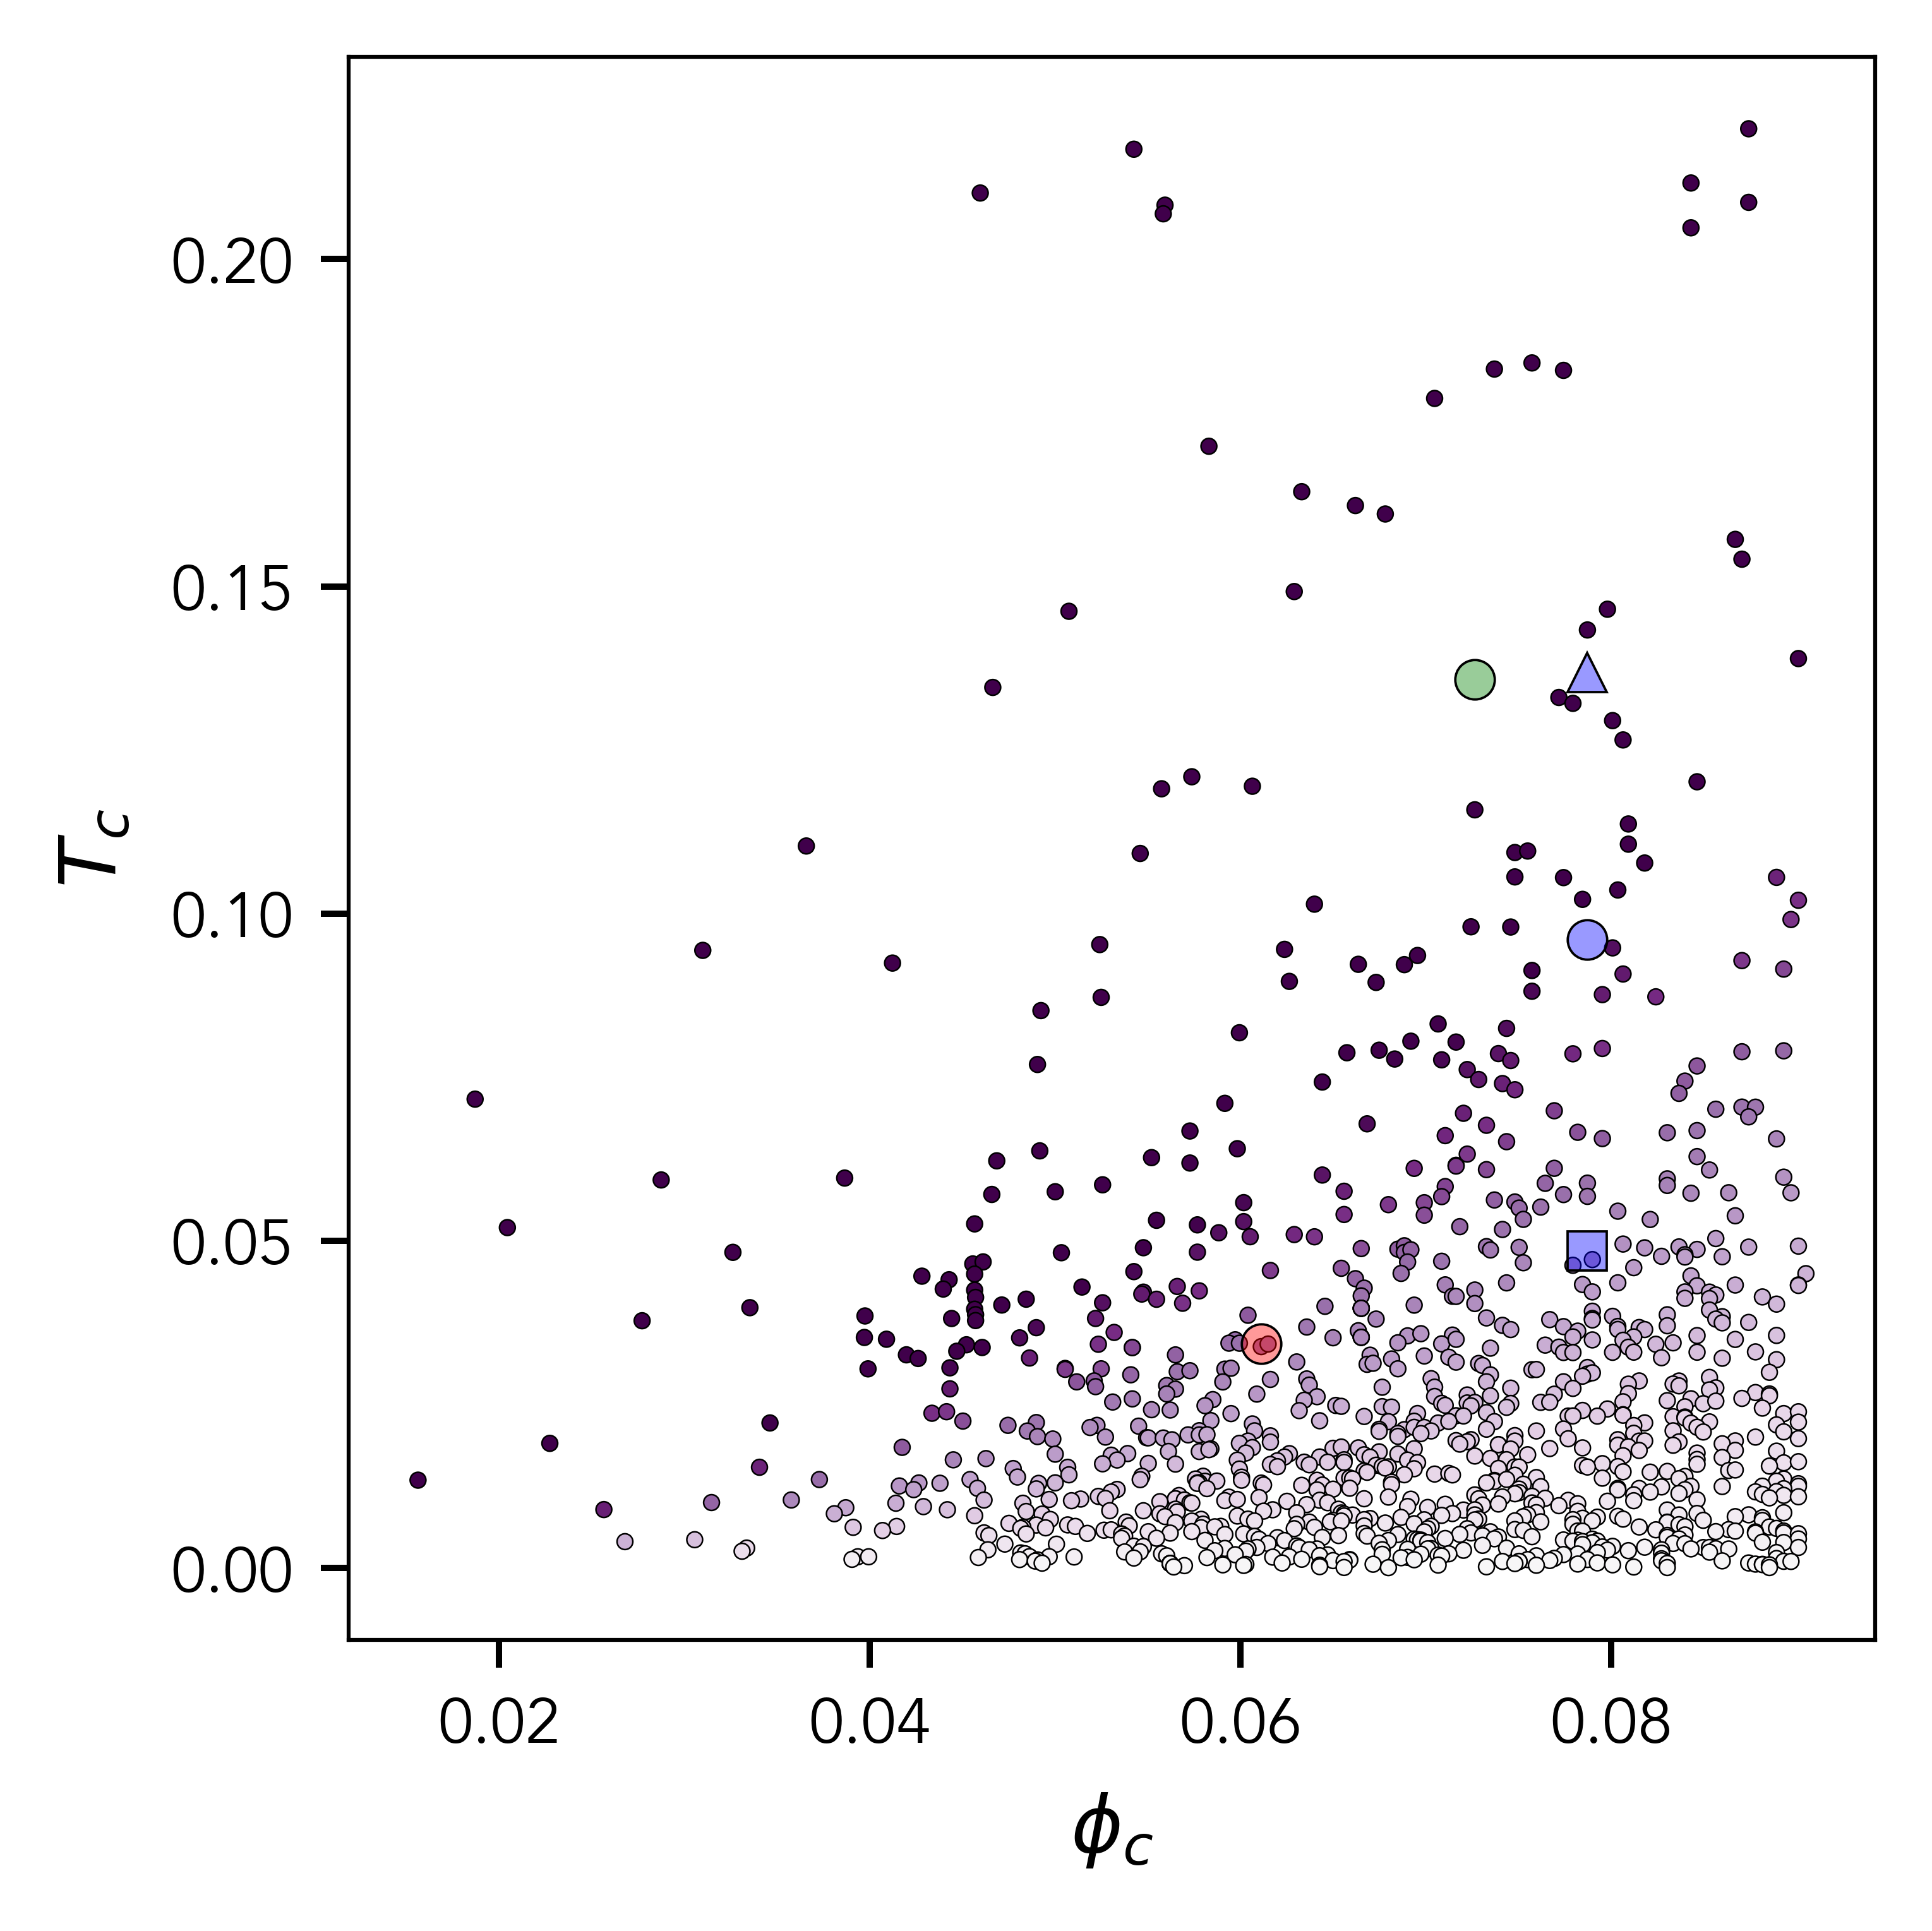

In [17]:
fig = plt.figure(figsize=(3.5, 3.5), dpi=450)
ax = plt.gca()

# emperically we define ranges here just to ensure color scale is appropriate
if mode == 'calvados':
    vmin = -20
    vmax = 20
elif mode == 'mpipi':
    vmin = -8
    vmax = 8

# plot all Phi_C (x) vs all T_C (y)
plt.scatter(all_phic, all_tc ,c=np.array(eps_above_thresh), cmap='PRGn', vmin=vmin,vmax=vmax, edgecolor='k', lw=0.2, s=4)

# plot the special sequences (we do twice so we can plot marker as with high transparency and then
# also draw a non-transparent border around that

# ddx4
plt.plot(ddx4_data[0], ddx4_data[1],'o',mfc='r', mew=00, alpha=0.4, ms=5)
plt.plot(ddx4_data[0], ddx4_data[1],'o',mfc='None', mew=0.3, alpha=1, ms=5, mec='k')

# fus ntd
plt.plot(fus_ntd_data[0], fus_ntd_data[1],'o',mfc='g', mew=00, alpha=0.4, ms=5)
plt.plot(fus_ntd_data[0], fus_ntd_data[1],'o',mfc='None', mew=0.3, alpha=1, ms=5, mec='k')

# a1 lcd wt
plt.plot(a1_lcd_data[0], a1_lcd_data[1],'o',mfc='b', mew=00, alpha=0.4, ms=5)
plt.plot(a1_lcd_data[0], a1_lcd_data[1],'o',mfc='None', mew=0.3, alpha=1, ms=5, mec='k')

# a1 aro plus
plt.plot(a1_aro_plus_data[0], a1_aro_plus_data[1],'s',mfc='b', mew=00, alpha=0.4, ms=5)
plt.plot(a1_aro_plus_data[0], a1_aro_plus_data[1],'s',mfc='None', mew=0.3, alpha=1, ms=5, mec='k')

# a1 aro minus
plt.plot(a1_aro_minus_data[0], a1_aro_minus_data[1],'^',mfc='b', mew=00, alpha=0.4, ms=5)
plt.plot(a1_aro_minus_data[0], a1_aro_minus_data[1],'^',mfc='None', mew=0.3, alpha=1, ms=5, mec='k')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r'$\phi_c$',fontsize=10)
plt.ylabel(r'$T_c$',fontsize=10)
plt.tight_layout()
plt.savefig(f'out_figures/tphi_vs_tc_{mode}.pdf')
